In [7]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import numpy as np
import tensorflow

In [2]:
class Value:
    def __init__(self, data, _children = (), _op = '',label  = ''):
        self.data = data    #this is simply initialising the Value object with the param value
        self.grad = 0.0 #the grad here is the derivative of node, or the Value object, with respect to the loss function, L in our case 
        self._prev = set(_children) #this is more like the parents, this is a set of the values on which some operation was done and this Value object was created 
        self._backward = lambda : None #this is the backprop property for every node, it's basically a function that's called with every operation
        self._op = _op #this holds the operation which derived the certain Value object (not all will have it ofc)
        self.label = label #this is simply the name given to the Value object, like a, b, c, L
    def __repr__(self):
        return f"Value(data = {self.data})" #this function is simply for representing the object in a nice-to-look-fashion
    
    def __add__(self, other): #`other` is like the other Value object with which we will be adding the current one 
        other = other if isinstance(other, Value) else Value(other) #this helps in doing something like adding a constant to a Value object.
        ret = Value(self.data + other.data, (self, other), '+')#on receiving a constant, we are simply wrapping it as a Value object internally 
        def _backward():
            self.grad += 1.0 * ret.grad #this is simply computing the gradient as per the operation being called which results in the output Value object
            other.grad += 1.0 * ret.grad
        
        ret._backward = _backward #so when the output node calls the function, the gradients of the nodes which led to the creation of the output nodes gets formed
        return ret #So we are basically returning another Value object 

    def __sub__(self, other):
        return self + (-1 * (other))
    
    def __rsub__(self, other):
        return self.__sub__(other)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def exp(self):
        ret =  Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += ret.data * ret.grad

        ret._backward = _backward
        return ret 

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data / other.data, (self, other), '/')
        def _backward():
            self.grad += (1/other.data) * ret.grad
            other.grad += -(self.data/math.pow(other.data, 2)) * ret.grad    
        
        ret._backward = _backward
        return ret 

    def __rtruediv__(self, other):
        return self.__truediv__(other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * ret.grad
            other.grad += self.data * ret.grad
        
        ret._backward = _backward
        return ret
    
    def __rmul__(self, other): #this is for, if we do stuff like 2*a instead of a*2, stands for right mul
        return self.__mul__(other) 
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(math.pow(self.data, other.data),(self,), '^')
        def _backward():
            self.grad += (other.data * math.pow(self.data, (other.data - 1))) * ret.grad

        ret._backward = _backward
        return ret 

    def relu(self):
        ret = Value(max(0, self.data), (self, ),'relu')
        def _backward():
            self.grad += ret.grad if ret.data>0 else 0.0
        
        ret._backward = _backward
        return ret
    
    def tanh(self):
        x = self.data #you get this formulation off Wikipedia 
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        ret = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * ret.grad
            
        ret._backward = _backward
        
        return ret

    def backward(self): #this is the actual backward function which you call on the final node, that's probably the "Loss" node
        topo = []
        visited = set()
        def topo_sort(node): #this is the topological sort function which sorts the nodes in the graph, from starting to end 
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    topo_sort(child)
                topo.append(node)
        
        topo_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo): #we want to call the self._backward() function from the last node to the beginning node
            node._backward() #and hence we reverse the sorted list and call the _backward() function on every node from the last



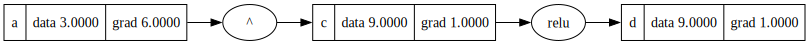

In [4]:
a = Value(3.0, label = 'a')
b = Value(2.0, label = 'b')
c = a**b; c.label = 'c'
d = c.relu(); d.label = 'd'

d.backward()
draw(d)


In [7]:
def check(num):
    return num>0

hold = check(1) + 1
hold


2

In [8]:
a = Value(2.0, label='a')
b = Value(-4.0, label='b')
c = Value(5.0, label='c')
e = a*b ; e.label = 'e' #this is the same as doing d = a.__mul__(b)
d = e + c; d.label = 'd'     
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data = 6.0)

In [14]:
!/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

zsh:1: command not found: curl


In [3]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, we are creating a node around it 
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is the result of some prior operation
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it 
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot 
        

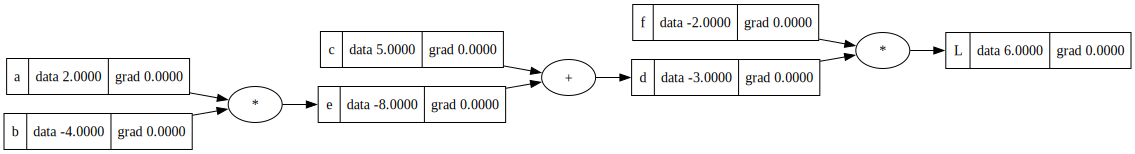

In [10]:
draw(L)

In [7]:
L.grad = 1.0
d.grad = -2.0
f.grad = -3.0
c.grad = -2.0
e.grad = -2.0
a.grad = 8.0
b.grad = -4.0

### Backpropagation by hand yay 



Now, we will be computing the gradients for every node, manually.

So, we will be computing the derivative of $L$, which is supposedly our mock loss function with every node in the graph (which can be considered the weights of nodes in the neural network).

Starting from L itself, we compute the derivative of $L$ with $L$. Now what does it mean intuitively to compute the partial derivative of something with something. $ \partial a / \partial b$ simply computes the change in $a$ when we increment $b$ by a very small amount. that's all.

So $\partial L / \partial L$ means how much will $L$ change if we bump $L$ by a small amount (lol). ofcourse, the derivative will be **1.0**, and yay! we have our first gradient of the graph.


Now moving onto the next one, what will $\partial L / \partial d$ will be? Again, all it means is that if we bump $d$ by a really tiny amount, how's that affecting $L$. So,

$\partial L / \partial d$ = ?¿

=> $\partial (d*f) / \partial d$

=> $f$

And there we have our second derivative.

Similarly for $\partial L / \partial f$ = $d$

With that, we complete the first layer of gradients from $L$.

Moving on to the second layer, we need to compute $\partial L / \partial c$.
Now, this is'nt as trivial as what we did for the last layer since $c$ and $e$ aren't direcly related to $L$; this is where we apply _chain rule_.

So, what are the things that we know already - 

$\partial L / \partial d$ = -2.0

$\partial L / \partial f$ = -3.0

We can compute $\partial d / \partial c$ pretty comfortably,
$\partial (c + e) / \partial c$ 

= $1$

now that we have $\partial L / \partial d$ and $\partial d / \partial c$,

$\partial L / \partial d * \partial d / \partial c$

= $-2.0 * 1$ = $-2.0$

Voila, we got it. Additions simply distribute the gradient of a node among it's children, every children gets the gradient of it's parent. Hence $\partial L / \partial e$ is $-2.0$ as well.

Applying the Chain Rule recursively, 

$\partial L / \partial a$

= $\partial L / \partial d * \partial d / \partial e * \partial e / \partial a$

= $-2.0 * 1.0 * -4.0$

=$8.0$


And for the last one, $\partial L / \partial b$ = $-4.0$

In [10]:
a.data += 0.001 * a.grad #here we are nudging the values of the leaf nodes, the ones which aren't derived of any calculation to see the effect on L
b.data += 0.001 * b.grad #we want L to go up, hence we are nudging the values in the direction of the gradient. Note that the exact opposite is done in gradient descent to minimize the loss
f.data += 0.001 * f.grad
c.data += 0.001 * c.grad
e = a*b ; e.label = 'e' #in this line and the following 2, we are re running the forward pass to emulate the changes after nuding the values 
d = e + c; d.label = 'd'     
L = d * f; L.label = 'L'

print(L.data)

6.182748767999997


In [177]:
#inputs  x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#intercept term or the bias
b = Value(6.8813736, label='b')
#we are simply computing ax+b that is x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b; n.label = 'n'

#now, we need to pass it through some activation function, say tanh

output = n.tanh(); output.label = 'o'

$\sum_{i=0}^{n} w_i x_i + b$


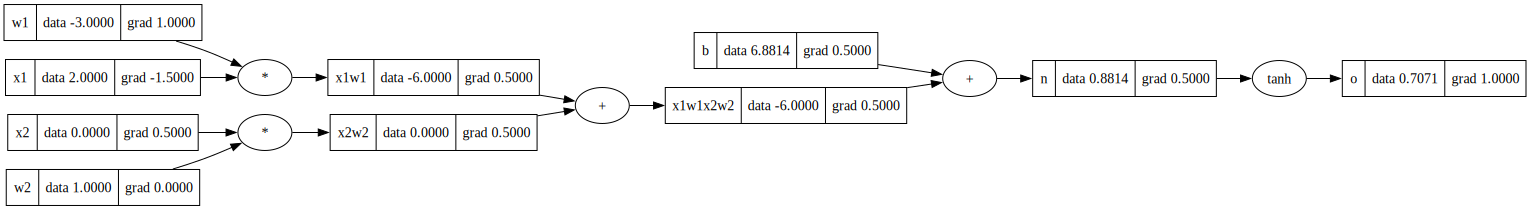

In [180]:
draw(output)

now let's manually compute the gradients for every node 

In [75]:
# output._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

Okay we have manually implemented backprop, but we don't want to call the `_backward` function on every node in the neuron, and we want to automate it.

Since we have laid out the neuron as a graph, we will be using topological sort to sort the graph from the beginning to the last node and then we can  call the `_backward` function on the list that we'll be having.

In [179]:
output.backward()

In [61]:
output.grad = 1.0
n.grad = 1 - output.data**2 #.42
b.grad = x1w1x2w2.grad = x1w1.grad = x2w2.grad =  0.5
w1.grad = x1w1.grad * x1.data
x1.grad = x1w1.grad * w1.data
w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data

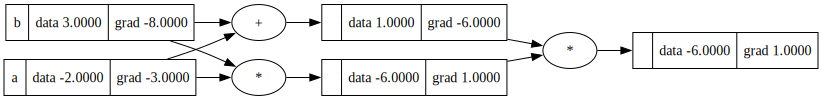

In [8]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')

d = a*b
e = a+b
f = e*d

f.backward()
draw(f)

So the gradients of a and b aren't quite right. The gradients are basically getting overriden if a certain node is being used more than once, the gradient becomes the last operation performed and not the total accumulation of the all operations performed on the nodes. easy fix in the `_backward` function

In [24]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813736]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b 
output = torch.tanh(n)

print(output.data.item())
output.backward()

print('-------------')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
-------------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


yay the output matches the loss backward function that we have coded 

In [9]:
import random
import math

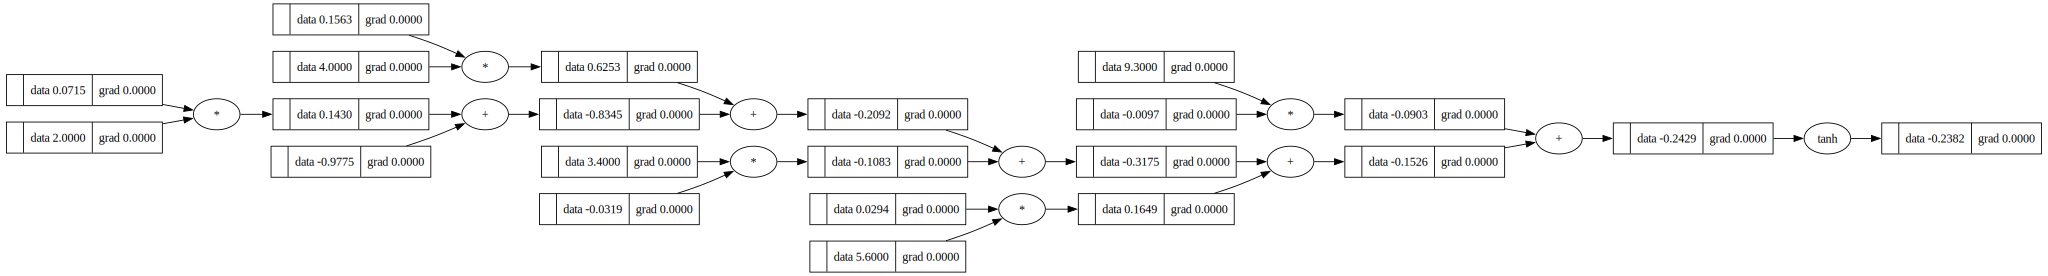

In [12]:
class Neuron:
    def __init__(self, shape):
        self.w = [Value(random.uniform(-1,1)) for _ in range(shape)] 
        self.b = Value(random.uniform(-1,1))
    
    def parameters(self):
        return self.w + [self.b]
    
    def __call__(self,x): #we are going to implement the forward pass in this method, that's w*x + b
        output = sum((wi*xi for wi,xi in zip(x, self.w)), self.b) #this is like implementing tf.matmul() 
        output = output.tanh() #zip(self.x, self.w) makes a list of tuples consisting of x and w values 
        return output


x = [2.0, 4.0, 3.4, 5.6, 9.3]
n = Neuron(len(x))
n.parameters()
draw(n(x))


In [19]:
class Layer: #its important to note that the layer is built just once during the initialisation of the object 
    def __init__(self, out, inputs = None):
        self.out = out 
        self.input = inputs # is now the list 
        self.built = False
    
    def parameters(self):
        ret = []
        for neuron in self.neurons:
            ret.extend(neuron.parameters())
        return ret
        
    
    def build(self):
        self.built = True
        self.neurons = [Neuron(len(self.input)) for _ in range(self.out)]

    def call(self):
        output = [n(self.input) for n in self.neurons] 
        return output[0] if len(output) == 1 else output

        
    def __call__(self):
        if not self.built:
            self.build()
        return self.call()
    
        


x = [3.0, 5.0, 2.773, 7.245]
layer  = Layer(3,x)
out = layer()
print(len(layer.neurons))
out

3


[Value(data = 0.958025105583658),
 Value(data = -0.9998420962262118),
 Value(data = -0.9999999574061088)]

In [20]:
class Network:
    def __init__(self, layers):
        self.layers = layers #the user will be giving a list of Layer objects 
        self.out = None
        self.loss = 0
    
    def get_params(self):
        ret = []
        for layer in self.layers:
            ret.extend(layer.parameters())
        
        return ret

    def __call__(self, inputs = None):
        if inputs is None:
            for i, layer in enumerate(self.layers):
                if i==0 and layer.input is None:
                    print('Kindly provide the input for the first layer')
                    return
            
                if layer.input is None:
                    layer.input = self.out
            
                self.out = layer() #out is a list of Value objects 
        
            return self.out
        else:
            self.out = inputs 
            for layer in self.layers:
                layer.input = self.out
                self.out = layer()
            
            return self.out
        
    def fit(self, data, labels, learning_rate = 0.05, epochs = 20):
        shape = np.array(data).shape
        res = []
        for k in range(epochs):
            #forward pass
            res = [self.__call__(i) for i in data] if len(shape) > 1 else [self.__call__()]
            self.loss = sum((ri - label)**2 for ri,label in zip(res,labels)) #mse loss 

            for p in self.get_params(): #this is an important step since we want to start every forward pass with a grad of 0, 
                p.grad = 0.0 #if this is not done, the gradients from the prior passes will keep adding up due to how backward is defined 

            #backprop
            self.loss.backward()

            #update 
            for p in self.get_params():
                p.data += -learning_rate * p.grad
            
            print(k+1, self.loss.data)
        
        return res
        


In [29]:
mat_net = Network([
    Layer(4),
    Layer(4),
    Layer(1)
])

mat = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

labels = [1.0, -1.0, -1.0, 1.0]

the forward pass and the loss computation

In [23]:
import numpy as np

1 4.221753001184251
2 5.157347774276069
3 4.788062474391178
4 4.715678771584072
5 3.836643005974336
6 3.4179979303437245
7 0.20972884961584265
8 0.04166023029644735
9 0.03459517152523308
10 0.03004957480428981
11 0.026775432712136314
12 0.02425671350707563
13 0.022234379733658036
14 0.02056126256382433
15 0.019146175228287356
16 0.017928874606679312
17 0.016867552620970668
18 0.01593204678066254
19 0.01509990522358109
20 0.014353981457658822
21 0.013680897917618385
22 0.01307002749
23 0.012512796785176111
24 0.012002196433036485
25 0.0115324287110629
26 0.011098648734045804
27 0.010696770897464505
28 0.010323321786218436
29 0.009975326787676556
30 0.00965022156089057
31 0.009345782111871712
32 0.009060068985295882
33 0.008791382298114887
34 0.008538225193440427
35 0.008299273900972088
36 0.008073353029657325
37 0.007859415040039374
38 0.007656523082185976
39 0.007463836563743093
40 0.007280598947884659
41 0.0071061273842653715
42 0.0069398038557517885
43 0.0067810675856352694
44 0.0066

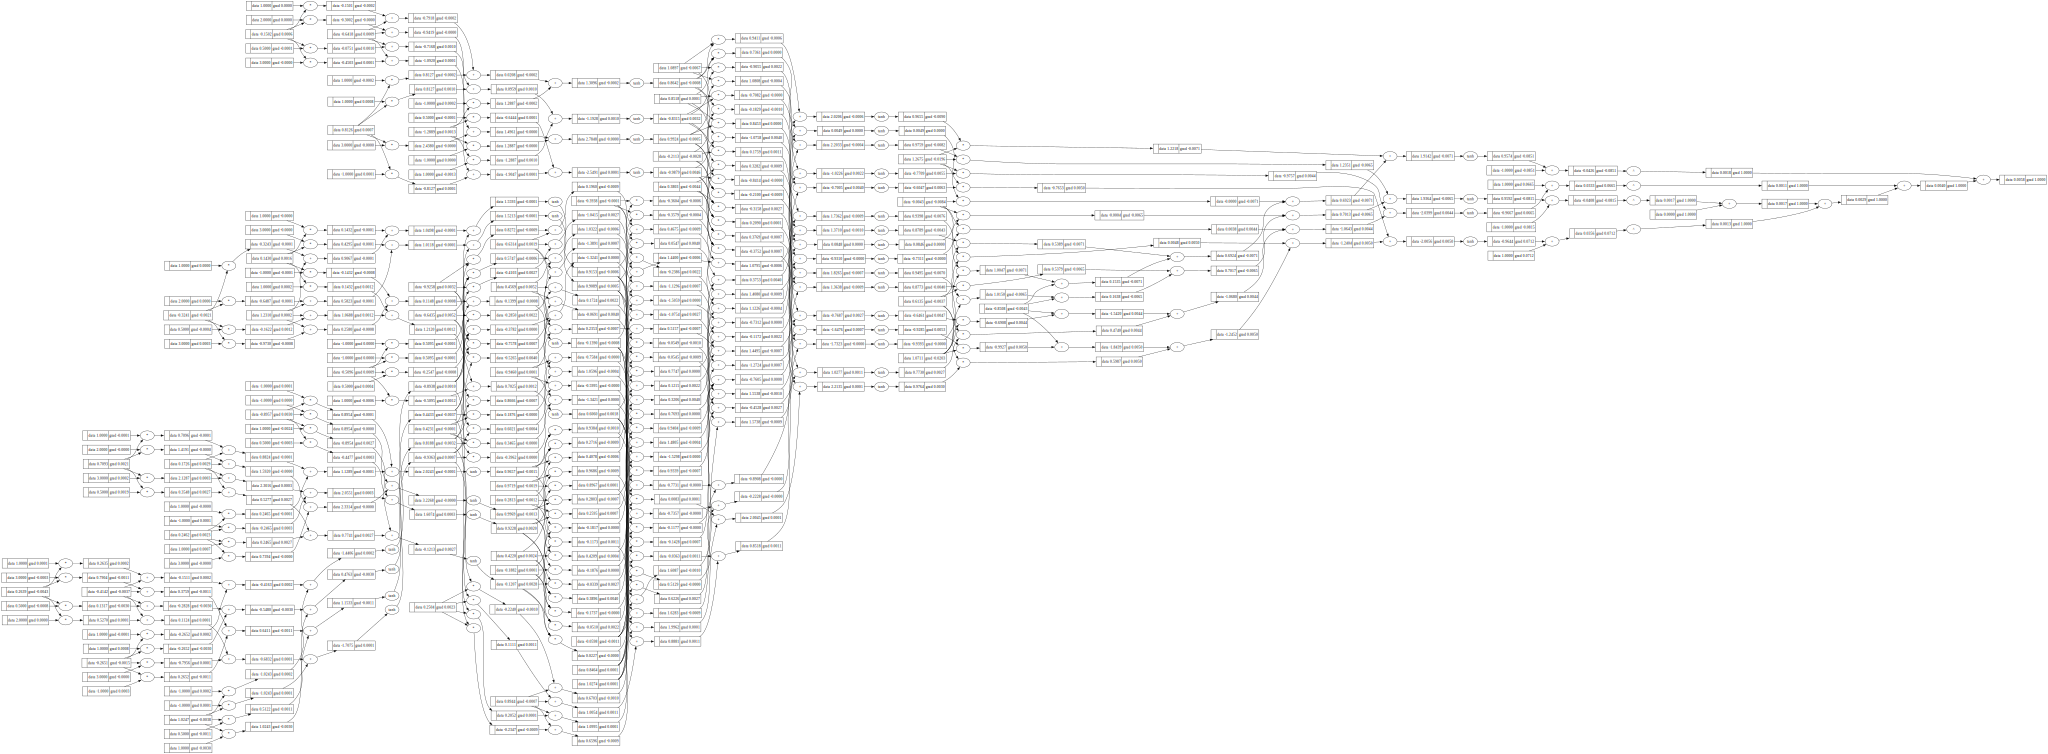

In [30]:
res = mat_net.fit(mat, labels, learning_rate = 0.1 ,epochs = 50)
draw(mat_net.loss)